In [1]:
from trainer import PyTorchTrainer
from q_lstm_torch import SimpleLSTM, SimpleQLSTM
from util.dataset_creator import create_dataset
from util.model_comparision import compare_models

import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

from q_lstm_torch import QLstm

## Load dataset

In [2]:
def load_data(path):
    data = np.load(path, allow_pickle=True)

    data = dict(enumerate(data.flatten(), 0))
    return torch.from_numpy(np.concat(data[0]['X'])).squeeze(), torch.from_numpy(np.concat(data[0]['y'])).squeeze().to(dtype=torch.long)

In [3]:
X_train, y_train = load_data('../data/numpy/train.npy')
X_val, y_val = load_data('../data/numpy/val.npy')
X_test, y_test = load_data('../data/numpy/test.npy')

X_train.shape


torch.Size([5600, 124, 129])

Take only labels 0 and 1

In [4]:
# indeces = torch.where((y_train == 0) | (y_train == 1))
# X_train, y_train = X_train[indeces], y_train[indeces]

# indeces = torch.where((y_val == 0) | (y_val == 1))
# X_val, y_val = X_val[indeces], y_val[indeces]

# indeces = torch.where((y_test == 0) | (y_test == 1))
# X_test, y_test = X_test[indeces], y_test[indeces]

# X_train.shape
# X_val.shape

In [5]:
X_train = torch.nn.functional.normalize(X_train, p=2.0, dim=1, eps=1e-12, out=None)
X_val = torch.nn.functional.normalize(X_val, p=2.0, dim=1, eps=1e-12, out=None)
X_test = torch.nn.functional.normalize(X_test, p=2.0, dim=1, eps=1e-12, out=None)

In [6]:
class ASRDataset(Dataset):
        def __init__(self, X, y):
            self.X = X
            self.y = y
            
        def __len__(self):
            return len(self.X)
        
        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

In [7]:
train_dataset = ASRDataset(X_train, y_train)
val_dataset = ASRDataset(X_val, y_val)
test_dataset = ASRDataset(X_test, y_test)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [9]:
class ASRLSTM(nn.Module):
    def __init__(self, input_features, num_chars):
        super(ASRLSTM, self).__init__()
        # Feature extraction with Conv1d and subsampling
        self.conv = nn.Sequential(
            nn.Conv1d(input_features, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
        )
        
        # Bidirectional LSTM layers
        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=512,
            num_layers=3,
            bidirectional=True,
            batch_first=True,
            dropout=0.2
        )
        
        # Final classification layer
        self.linear = nn.Linear(8192, num_chars)  
        
        # Weight initialization
        self._init_weights()

    def _init_weights(self):
        # LSTM weight initialization
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                if 'weight_ih' in name:
                    nn.init.xavier_normal_(param)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)
                # Initialize forget gate bias to 1
                n = param.size(0)
                param.data[n//4:n//2].fill_(1.0)
        
        # Conv layer initialization
        for layer in self.conv:
            if isinstance(layer, nn.Conv1d):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)
        
        # Linear layer initialization
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.constant_(self.linear.bias, 0)

    def forward(self, x):
        # Input shape: (batch_size, seq_len, input_features)
        x = x.permute(0, 2, 1)  # [batch, features, seq_len]
        
        # Feature extraction
        x = self.conv(x)
        
        # Prepare for LSTM
        x = x.permute(0, 2, 1)  # [batch, seq_len, features]
        
        # Pack padded sequence

        output, _ = self.lstm(x)
        output = output.flatten(start_dim =1)
        # Classification layer
        logits = self.linear(output)  # [batch, seq_len, num_chars + 1]
        log_probs = nn.functional.log_softmax(logits, dim=1)
        return log_probs
    
    def predict(self, x):
        log_probs = self(x)
        return torch.argmax(log_probs, dim=1)
       
lstm = ASRLSTM(input_features=129, num_chars=8)
#qlstm = LstmASR(QLstm(6, 2, feature_dim=4), nn.Linear(31*6, 2))
print(X_test.shape)
print(lstm(X_test[:2]).shape)




torch.Size([1216, 124, 129])
torch.Size([2, 8])


In [11]:
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(lstm.parameters())

lstm_trainer = PyTorchTrainer(
    lstm,
    train_dataloader,
    loss_fn,
    optim,
    val_dataloader,
    epochs=100,
    checkpoint_dir='checkpoints/asr/lstm',
    device='cuda',
    model_name='model_4'
)

lstm_trainer.fit(True)
preds = lstm_trainer.model.predict(X_test.to('cuda'))
print(torch.sum(preds.cpu().detach() == y_test)/y_test.size(0))
preds = lstm_trainer.model.predict(X_train.to('cuda'))
print(torch.sum(preds.cpu().detach() == y_train)/y_train.size(0))


Epoch 100/100 - Train loss: 2.0794 - Val loss: 2.0804 - Best val: 2.0796: 100%|██████████| 100/100 [01:40<00:00,  1.01s/it]


tensor(0.1324)
tensor(0.1279)


: 

In [11]:
lstm_trainer.val_losses

[2.084578005043236,
 2.0856418738494047,
 2.0853477362039925,
 2.0887678313899682,
 2.0813699670740076,
 2.0895184310706885,
 2.0818078646788725,
 2.0832377768851615,
 2.084108977704435,
 2.0818596981667183,
 2.0828823849961564,
 2.085268542573259,
 2.0865863722723885,
 2.083294965125419,
 2.0850514463476233,
 2.0856566300263277,
 2.0818714708895296,
 2.104600242666296,
 2.0868993772042765,
 2.0873539834409147,
 2.089258438832051,
 2.1095750009691394,
 2.1024888077297725,
 2.149751875851605,
 2.1095652966885954,
 2.124833293863245,
 2.1859696555782007,
 2.1964994958929114,
 2.229084601273408,
 2.212803789087244,
 2.37448652370556,
 2.281296427185471,
 2.462237783380457,
 2.670803804655333,
 2.6639006266722807,
 2.7975148639163456,
 3.0935139462754533,
 3.3135777937399373,
 3.5033349990844727,
 3.8231422192341573,
 4.317036151885986,
 5.326761013752705,
 5.248098992012642,
 5.877390049599312,
 6.409534093495962,
 6.512499731940192,
 6.97192975637075,
 7.337088430250013,
 7.6122746338715

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(qlstm.parameters())

qlstm_trainer = PyTorchTrainer(
    qlstm,
    train_dataloader,
    loss_fn,
    optim,
    val_dataloader,
    epochs=10,
    checkpoint_dir='checkpoints/asr/qlstm'
) 

qlstm_trainer.fit(True)

NameError: name 'qlstm' is not defined

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

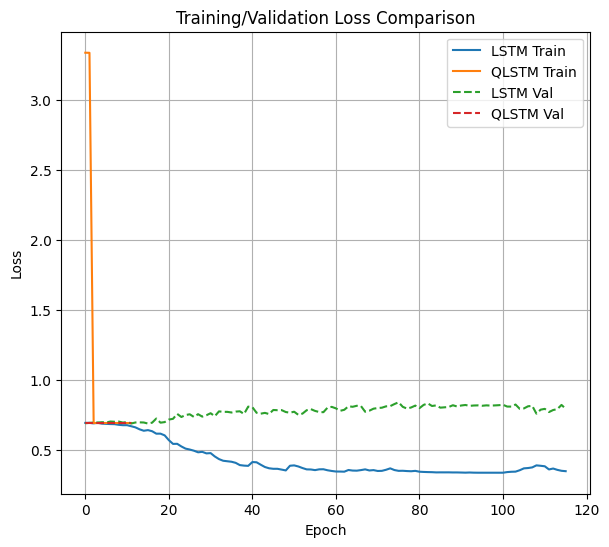

In [12]:
compare_models(lstm_trainer, qlstm_trainer, test_dataloader, ['LSTM', 'QLSTM'])